 
<center><h1>Oblig 2 MAT4110, UiO</h1></center>
<center>Halvard Sutterud</center>

In this oblig, we will study how the SVD-decomposition can be used to compress an image. We start by downloading three images, found at the following web pages, 

- https://pixabay.com/en/board-chess-chessboard-black-white-157165/
- https://pixabay.com/en/jellyfish-under-water-sea-ocean-698521/
- https://pixabay.com/en/new-york-city-skyline-nyc-690868/

We first need some code to load and process data

In [1]:
# standard python magics and imports
%load_ext autoreload
%autoreload 2
import numpy as np  
import matplotlib.pyplot as plt

from oblig2 import get_data
from scipy.linalg import svd
from scipy.ndimage import imread 
plt.rcParams['image.cmap'] = 'Greys'

In [2]:
def get_data(fname, plot = False, ax = None):
    """Function to read data"""
    img = plt.imread(fname)
    if plot:
        if ax is None:
            plt.figure()
            ax = plt.gca()
        ax.imshow(img)
        ax.set_title(fname)
    img = img[:,:,:3]

    if img.dtype == 'uint8':
        return np.array(img,dtype = np.float32)/255
    else:
        return img

Here we have the images in question

max values: 1.0, 1.0, 1.0


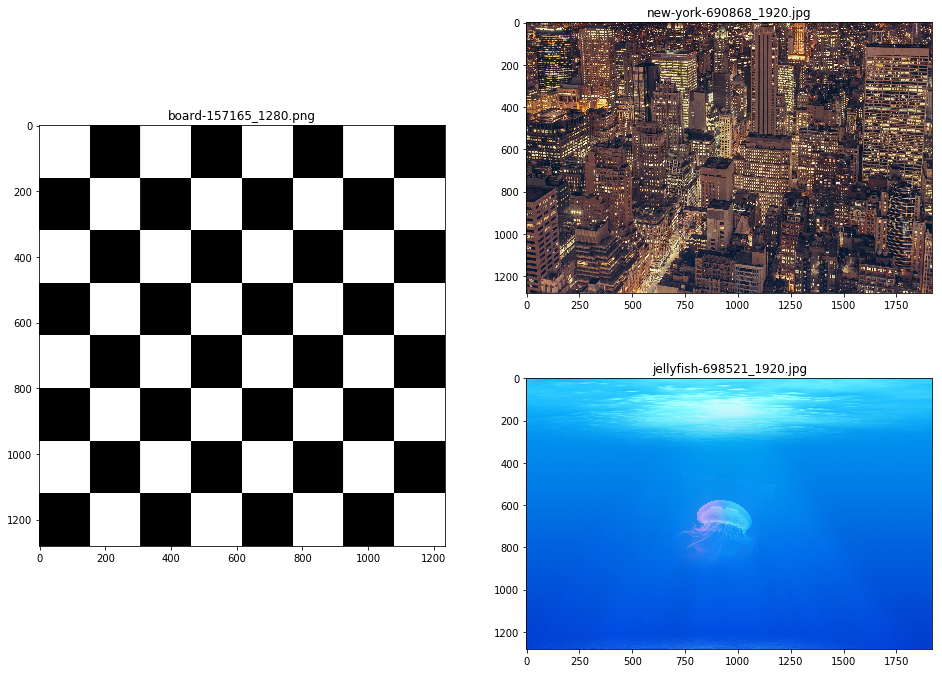

In [3]:
# our novel work
fig = plt.figure(figsize = [16,12])
board = get_data('board-157165_1280.png', plot = True, ax = fig.add_subplot(121))
newyo = get_data('new-york-690868_1920.jpg', plot = True, ax = fig.add_subplot(222))
jelly = get_data('jellyfish-698521_1920.jpg', plot = True, ax = fig.add_subplot(224))
print("max values: {}, {}, {}".format(np.max(board),np.max(jelly),np.max(newyo)))

# Convert to greyscale
board = np.mean(board, axis = 2)
jelly = np.mean(jelly, axis = 2)
newyo = np.mean(newyo, axis = 2)

images = {'Board':board, 'Jelly':jelly, 'New York':newyo}

We can now perform a SVD-decomposition on the $n\times  m$ arrays we have obtained. From [1] we have that
for any matrix $A \in \mathbb{C}^{n\times m}$, an SVD decomposition exists such that

\begin{equation} \label{eq:svd}
    A = U\Sigma V^T,
\end{equation}

where $U$ and $V$ are unitary matrices whose columns are the orthonormal eigenvectors of $AA^T$ and $A^T A$ respectively, and 

\begin{equation}\label{eq:Sigma}
    \Sigma = 
    \begin{bmatrix}
        \Sigma_1 & 0 \\ 0 & 0
    \end{bmatrix} \in \mathbb{C}^{m \times n},
\end{equation}

is a block matrix, where the non-zero block is a diagonal matrix $\Sigma_{1,ij} = \sigma_i\delta_{ij}$ consisting of the singular values $\sigma_i$. The $\sigma_i$'s are ordered such that $\sigma_1 \geq \dots \geq \sigma_r > \sigma_{r+1} = \dots = \sigma_{\min(m,n)} = 0$, where $r$ is the rank of $A$. As the singular values are in decreasing order, we can chose to exclude a number of values under a certain threshold. Doing this, we only need to keep a part of the upper block of $\Sigma$, which then lets us exclude both columns of $U$ and rows of $V^T$.

The compression ratio is given by
$$\text{compression ratio} = \frac{\text{uncompressed size}}{\text{compressed size}}$$.
For an $n\times m$ matrix, we arbitrarily let each element take 1 unit of disk or RAM space. The total uncompressed size is then $S_0 = nm$ units. If we then do the SVD decomposition and only keep the $r$ first singular values, then we need to store the $r$ first columns of $U$, $r$ singular values, and the $r$ first rows of $V$. The compressed size then becomes $S_1 = nr + r + mr$ units, where $r \leq \text{min}(m,n)$. We get

$$\text{compression ratio} = \frac{nm}{r(n+m+1)}$$. 

For our images with specific $n,m$, we can then take a look at the inverse compression ratio as a function of $r$.

Board maximal r for compression: 629/1236
Jelly maximal r for compression: 768/1280
New York maximal r for compression: 768/1280


(0, 5)

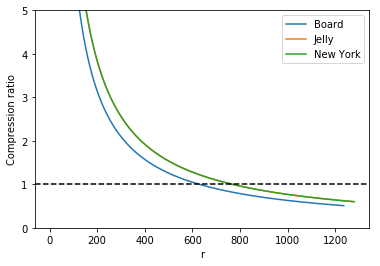

In [4]:
def compression(r,n,m):
    return n*m/(r*(n+m+1))

for name in ['Board','Jelly','New York']:
    arr = images[name]
    n,m = arr.shape
    r = np.arange(1, np.min((n,m)))
    comp =compression(r,n,m)
    
    plt.plot(r, comp, label= name)
    print('{} maximal r for compression: {}/{}'.format(name, r[np.argmin(np.abs(comp - 1))], np.min([n,m])))

plt.xlabel('r')
plt.ylabel('Compression ratio')
plt.axhline(1, linestyle='--', color = 'k')
plt.legend()
plt.ylim([0,5])

This shows that to obtain a compression ratio of more than one, which corresponds to the compressed size being smaller than the uncompressed we need to throw away at least $1236 - 629 = 607$ singular values in the chessboard case, and $1280 - 768 = 512$ in the jellyfish and New York cases

We will now perform the singular value decomposition. This can be done with scipy in the following way

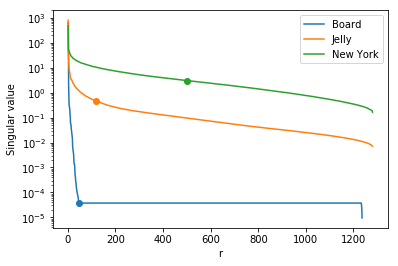

In [5]:
fig1, ax1 = plt.subplots(1)

r_values = {'Board':45, 'New York':500, 'Jelly':120}
svds = {}

for name in ['Board','Jelly','New York']:
    arr = images[name]
    m, n = arr.shape
    u,s,v = svd(arr, full_matrices=True)
    
    # store data
    svds[name] = [u,s,v]
    
    # plot singular values
    r = np.arange(1, s.size+1)
    ax1.semilogy(r, s, label = name)
    
    # show chosen value of r
    nice_r = r_values[name]
    ax1.scatter(nice_r, s[nice_r])
    
    ax1.legend()
    ax1.set_xlabel('r')
    ax1.set_ylabel('Singular value')

As seen in the resulting plot, in the chessboard image we get all the relevant singular values with an $r$ of 45, as the flat line probably corresponds to singular values which are non zero only because of loss of numerical precision. In this case we get a compression ratio of 

$$\text{compression ratio chessboard} = \frac{1280\times 1236}{45(1236+1280+1)} = 13.97$$

Visually, we can the results are really close to the uncompressed image

r_value:  45
compression: 13.97 
0.5064655390372168


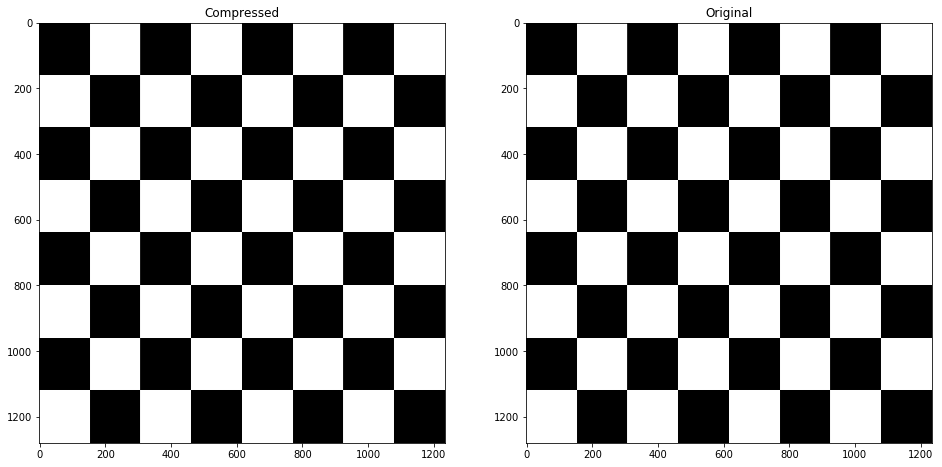

In [6]:
def compressed_image(u,s,v,r):
    return (u[:,:r] * s[:r]) @ v[:r]
    
name = 'Board'
u,s,v = svds[name]
arr = images[name]

r_value = r_values[name] 
n,m = arr.shape
print('r_value: ', r_value)
print('compression: {:.2f} '.format(compression(r_value,n,m)))

fig,[ax1,ax2] = plt.subplots(1,2, figsize = [16,9] )
compr = compressed_image(u,s,v,r_value)
ax1.imshow(compr)
ax1.set_title('Compressed')
ax2.imshow(arr)
ax2.set_title('Original')
print(np.mean(np.isclose(arr,compr)))

The high compression rate in this case is probably because little information is stored in the image. Theoretically one can imagine even less data used to store it, as one can reproduce the image with only a few simple lines of code. 

The jellyfish image also contains relatively little information, and 120 is deemed an visually acceptable $r$-value when we zoom in to the tentacles of the jelly. This gives an compression ratio of 6.4.

r_value:  120
compression: 6.40 


Text(0.5,1,'Original')

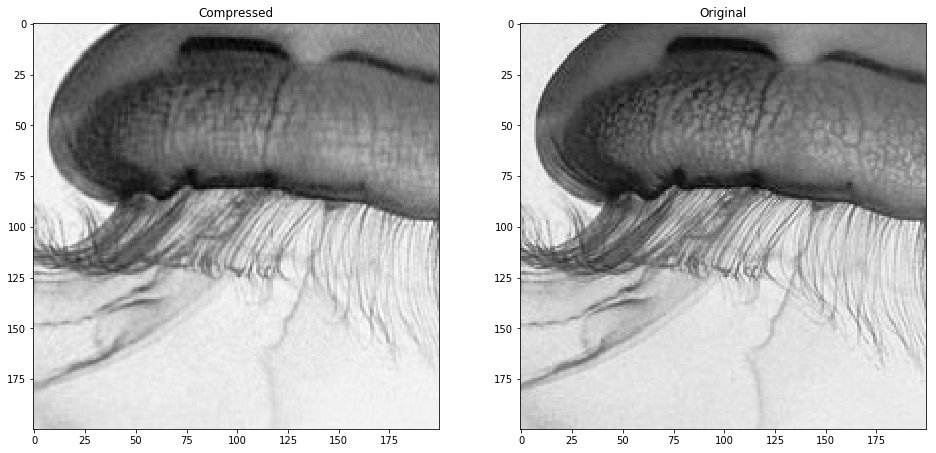

In [7]:
name = 'Jelly'
u,s,v = svds[name]
arr = images[name]
fig,[ax1,ax2] = plt.subplots(1,2, figsize = [16,9] )

r_value = r_values[name] 
n,m = arr.shape
print('r_value: ', r_value)
print('compression: {:.2f} '.format(compression(r_value,n,m)))

compr = compressed_image(u,s,v,r_value)
x = slice(800,1000)
y = slice(600,800)
ax1.imshow(compr[y,x])
ax1.set_title('Compressed')
ax2.imshow(arr[y,x])
ax2.set_title('Original')

Finally we have the image of New York, which can be characterized as a very busy image. This makes the compression less successful, as there is less redundant information stored in the pixels. Zooming in to a building, we find a proper number of singular values to be $r = 500$, which gives a compression ratio of 1.54.

r_value:  500
compression: 1.54 


Text(0.5,1,'Original')

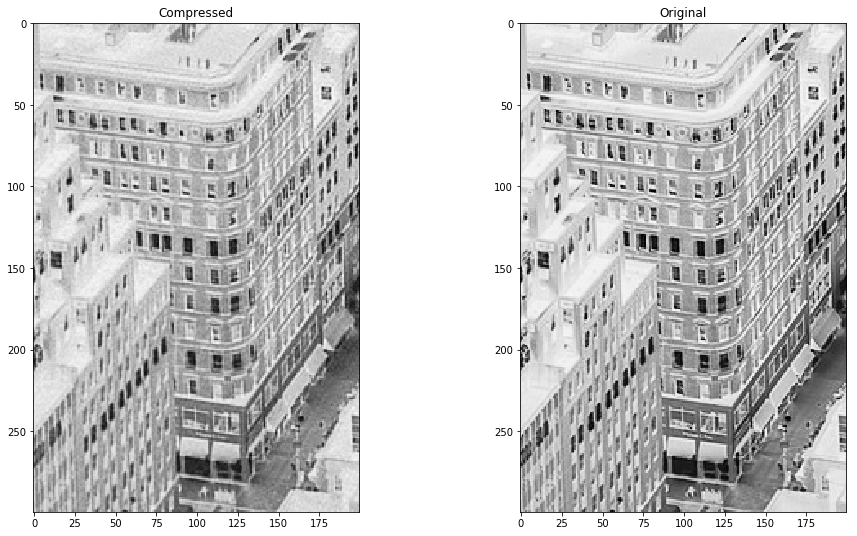

In [8]:
name = 'New York'
u,s,v = svds[name]
arr = images[name]
fig,[ax1,ax2] = plt.subplots(1,2, figsize = [16,9] )

r_value = r_values[name] 
n,m = arr.shape
print('r_value: ', r_value)
print('compression: {:.2f} '.format(compression(r_value,n,m)))

compr = compressed_image(u,s,v,r_value)
x = slice(500,700)
y = slice(900,1200)
ax1.imshow(compr[y,x])
ax1.set_title('Compressed')
ax2.imshow(arr[y,x])
ax2.set_title('Original')

# References
[1] H. Aabø, H. Sutterud, Project 1 in FYS-STK 4155: Data Analysis and Machine Learning, UiO. https://github.com/halvarsu/FYS-STK4155/blob/master/project1/FYS_STK4155.pdf